In [1]:
import pandas as pd
import numpy as np
import math
from scipy.interpolate import interp1d
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
version = 'Base' #'wo_CO2_budget' #'w_EV_exp' #'w_Tran_exp' #'w_Retro'#'w_DH_exp' #'Base' #'wo_CO2_budget' 
co2_1990 = 2232e6 # Mt co2 emission in 1990
rate = 0.02 # social discount rate, assumed equal to inflation rate averged for the the 20 paste years in Europe
years = np.arange(2020,2055,5)
today_TV = 31 #today transmission volume

sns.set_style("ticks")
figsize=(12.8,8)
fs = 20
fs_s = 18
mew = 3
ms = 8
lw = 3
color_cf = 'r'
color_pene = 'w'
#gathering all gas-fueled technologies
dict_rename_gas = {'gas boiler':'gas',
                   'gas CHP':'gas',
                   'CCGT':'gas',
                   'gas CHP heat':'gas',
                   'OCGT':'gas'}
#gathering technologies in simplified categories
dict_rename_simplified_cate = {'lignite':'conventional', 
                               'coal':'conventional', 
                               'gas':'conventional', 
                               'oil':'conventional',
                               'heat pump':'power-to-heat', 
                               'resistive heater':'power-to-heat', 
                               'hot water storage':'balancing', 
                               'battery storage': 'balancing', 
                               'hydrogen storage':'balancing', 
                               'methanation':'balancing',
                               'offshore wind':'wind and solar', 
                               'onshore wind':'wind and solar', 
                               'solar PV':'wind and solar',
                               'biomass CHP electric':'biomass', 
                               'biomass HOP':'biomass', 
                               'biomass EOP':'biomass',
                                'transmission lines':'transmission'}

tech_colors = pd.read_csv('../color_scheme.csv',index_col=0,squeeze=True)

In [3]:
def rename_techs(label):
    if label[:8] == "central ":
        label = label[8:]
    if label[:6] == "urban ":
        label = label[6:]
    if "retrofitting" in label:
        label = "building retrofitting"
    if "H2" in label:
        label = "hydrogen storage"
    if "gas CHP" in label:
        label = "gas CHP"
    if "biomass" in label:
        label = "biomass"
    if "water tank" in label:
        label = "water tanks"
    if label=="water tanks":
        label = "hot water storage"
    if "gas" in label and label != "gas boiler" and label != "gas cooler":
        label = "gas"
    if "OCGT" in label:
        label = "gas turbine"
    if "CCGT" in label:
        label = "gas turbine"
    if "nuclear" in label:
        label = "nuclear"
    if "lignite" in label:
        label = "lignite"
    if "coal" in label:
        label = "coal"
    if "solar thermal" in label:
        label = "solar thermal"
    if label == "oil store":
        label = "oil"
    if label == "solar":
        label = "solar PV"
    if "heat pump" in label:
        label = "heat pump"
    if label == "Sabatier":
        label = "methanation"
    if label == "offwind":
        label = "offshore wind"
    if label == "onwind":
        label = "onshore wind"
    if label == "ror":
        label = "hydro"
    if label == "hydro":
        label = "hydro"
    if label == "PHS":
        label = "hydro"
    if "battery" in label:
        label = "battery storage"

    return label

In [4]:
#CO2 fuel intentisites
d = {'gas':0.200975592195262,
     'coal':0.336125711,
     'lignite':0.4069083447,
     'oil':0.2664698682,
    }
co2_intensity = pd.Series(d)

In [5]:
csvs = {}
base_dir = '../results/version-{}/csvs'.format(version)
csvs['costs'] = pd.read_csv('{}/costs.csv'.format(base_dir),index_col=[0,1,2],header=[0,2])
csvs['energy'] = pd.read_csv('{}/energy.csv'.format(base_dir),index_col=[0,1],header=[0,2])
csvs['supply'] = pd.read_csv('{}/supply.csv'.format(base_dir),index_col=[0,1,2],header=[0,2])
csvs['metrics'] = pd.read_csv('{}/metrics.csv'.format(base_dir),index_col=0,header=[0,2])
csvs['curtailment'] = pd.read_csv('{}/curtailment.csv'.format(base_dir),index_col=0,header=[0,1],skiprows=[1,3])

In [6]:
df = csvs['energy']

total_demand = -df.loc['loads'].sum()

df = df.loc['stores'].rename(mapper=rename_techs)
df = df.groupby(df.index).sum()
df = df.reindex(index=co2_intensity.index)

s_emi = df.multiply(co2_intensity,axis=0).sum()
s_emi = s_emi/co2_1990
s_uti = s_emi

In [7]:
df = csvs['costs']
s = df.sum()

# Add distribution network costs based on PV capacity expost
def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    if isinstance(r, pd.Series):
        return pd.Series(1/n, index=r.index).where(r == 0, r/(1. - 1./(1.+r)**n))
    elif r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n
df_cap = csvs['metrics']
dist_net_cost=140*1000*(annuity(30,0.07)+0.03)*0.5*df_cap.loc['solar capacity'] # 140 €/kW PV installed, 30 years lifetime, 3% FOM, 50% of PV in rooftops
s+=dist_net_cost
saved_s=s
#discount annualised system cost
s = s.divide((1+rate)**(s.index.get_level_values(1).astype(int)-2020))
s_n = {}
#cumulative cost=intermediate cost*5years
s_n['go'] = (s['go'].sum()+s['go'].iloc[1:-1].sum())/2*5/1e9
s_n['wait'] = (s['wait'].sum()+s['wait'].iloc[1:-1].sum())/2*5/1e9

s_tr = csvs['metrics'].loc['transmission capacity']

to_drop = df.index[df.max(axis=1) < 1]
df = df.drop(to_drop)
df = df.droplevel(0)
df.rename(level=1,mapper=rename_techs,inplace=True)

In [8]:
# checking impact of social discount rate on gentle vs sudden comparison
#if version == 'Base':
#    rates = np.linspace(0,0.15,30)
#    plt.rcParams['xtick.labelsize'] = fs
#    plt.rcParams['ytick.labelsize'] = fs
#    fig,ax=plt.subplots(figsize=figsize)
#    for rate in rates:
#        s_n={}
#        s_s = saved_s.divide((1+rate)**(s.index.get_level_values(1).astype(int)-2020))
#        #cumulative cost=intermediate cost*5years
#        s_n['go'] = (s_s['go'].sum()+s_s['go'].iloc[1:-1].sum())/2*5/1e9
#        s_n['wait'] = (s_s['wait'].sum()+s_s['wait'].iloc[1:-1].sum())/2*5/1e9  
#        ax.scatter(rate,s_n['go'],c='r',s=100,label='Gentle')
#        ax.scatter(rate,s_n['wait'],c='b',marker='x',s=100,label='Sudden')
#    
#    handles,labels = ax.get_legend_handles_labels()
#    ax.legend(handles[:2],labels[:2],fontsize=fs)
#    ax.set_xlabel('Rate',fontsize=fs)
#    ax.set_ylabel('Net present cost',fontsize=fs)
#    plt.savefig('rate_vs_npc.pdf')

In [9]:
#LCOE calculation
df_cc = df.droplevel(0).groupby(level=0).sum()/total_demand
df_cc = df_cc.rename(dict_rename_gas)
df_cc = df_cc.groupby(by=df_cc.index).sum()

df_cc = df_cc.rename(mapper=dict_rename_simplified_cate).groupby(level=0).sum()
df_cc = df_cc.reindex(['conventional','nuclear','hydro','biomass','wind and solar',
                       'power-to-heat','balancing','transmission'])

# Add distribution network costs based on PV capacity expost
df_cc.loc['distribution']=dist_net_cost/total_demand

df_mc = df.loc['marginal'].rename({'gas turbine':'gas'}).groupby(level=0).sum()/total_demand
df_mc = df_mc.reindex(['lignite', 'coal', 'gas','nuclear'])


In [10]:
df = csvs['metrics'].filter(like='uti',axis=0)
df.rename(lambda x:x[:-4],inplace=True)
#df = df.rename(dict_rename_gas).groupby(level=0).mean()
#df = df.reindex(df_mc.index)
#df_uti = df
df_uti=df.loc[['nuclear', 'coal', 'lignite', 'OCGT', 'CCGT', 'gas boiler']]


C:\Users\34620\.conda\envs\env_pypsa\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [11]:
df_ex = csvs['metrics'].filter(like='expansion',axis=0)
df_ex = df_ex.rename(lambda x:x[:-10])/1e3 # GW per year
df_ex.rename(mapper=rename_techs,inplace=True)
df_ex = df_ex.groupby(df_ex.index).sum()
df_ex = df_ex.reindex(['lignite', 'coal', 'oil', 'gas turbine', 'gas boiler', 'nuclear',
                       'heat pump', 'resistive heater',
                       'hot water storage', 'hydrogen storage',
                       'offshore wind', 'onshore wind',  'solar PV'])
df_ex.loc['heat pump']*=4 # heat pump electric capacity converted into heating capacity
# df_ex.loc['transmission lines','go'] = s_tr['go'].values-np.insert(s_tr['go'].values[:-1],0,today_TV)
# df_ex.loc['transmission lines','wait'] = s_tr['wait'].values-np.insert(s_tr['wait'].values[:-1],0,today_TV)
df_ex.loc['transmission lines','go'] = s_tr['go'].diff().fillna(0).values/1e3
df_ex.loc['transmission lines','wait'] = s_tr['wait'].diff().fillna(0).values/1e3
df_ex.clip(lower=0,inplace=True)

In [12]:
renewable = ['onshore wind', 'offshore wind', 'solar PV']
conventional = ['lignite', 'coal', 'oil', 'gas turbine', 'gas boiler', 'nuclear']
PtH = ['heat pump', 'resistive heater']
balancing = ['battery storage', 'hydrogen storage', 'hot water storage', 'methanation', 'transmission'] #,'biomass storage']

In [13]:
df_capa = csvs['metrics'].filter(like='capacity',axis=0)
df_capa = df_capa.rename(lambda x:x[:-9])/1e3 #GW
df_capa = df_capa.rename(mapper=rename_techs).groupby(level=0).sum()

# Plot figure with LCOE decomposition

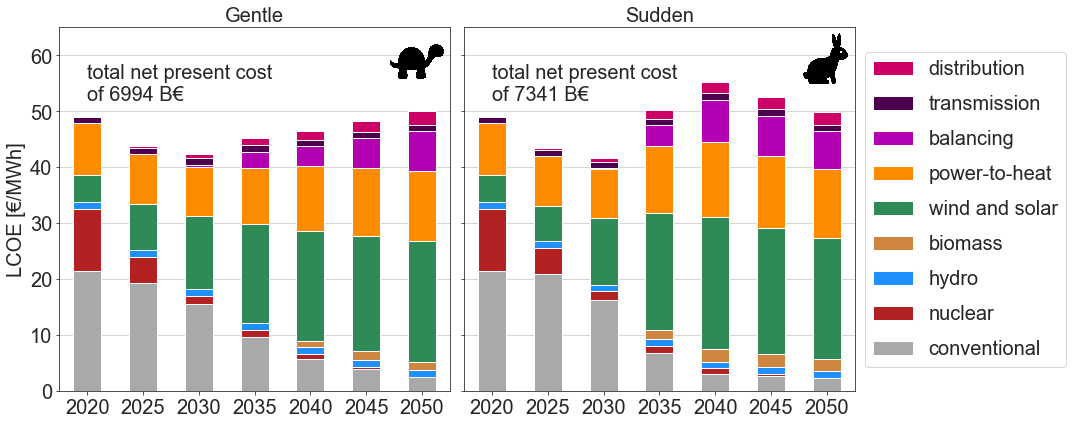

In [14]:
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox
def place_image(im, loc=3, ax=None, zoom=1, **kw):
    if ax==None: ax=plt.gca()
    imagebox = OffsetImage(im, zoom=zoom)
    ab = AnchoredOffsetbox(loc=loc, child=imagebox, frameon=False, **kw)
    ax.add_artist(ab)
im_tortoise = plt.imread('../../figures/tortoise.png')    
im_hare = plt.imread('../../figures/hare.png')  
fig, axes = plt.subplots(1,2,figsize=(15,6),sharex=True,sharey='row')

ax = axes[0]
df = df_cc['go']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs,rot=0)
ax.set_ylim([0,65])
ax.set_xlabel('')
ax.set_ylabel("LCOE [€/MWh]",fontsize=fs)
ax.set_title('Gentle',fontsize=fs)
ax.grid('on',axis='y')
ax.annotate('total net present cost \nof {} B€'.format(int(s_n['go'])),xy=(0,52),fontsize=fs)

place_image(im_tortoise, loc='upper right', ax=ax, pad=0, zoom=0.1)
# ax_twin = ax.twinx()
# s_emi['go'].plot(ax=ax_twin,fontsize=fs,color='k',lw=lw)
# ax_twin.set_ylim([0,1])
# ax_twin.set_yticks([])

ax = axes[1]
df = df_cc['wait']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs,rot=0)
ax.set_xlabel('')
ax.set_title('Sudden',fontsize=fs)
ax.grid('on',axis='y')
ax.annotate('total net present cost \nof {} B€'.format(int(s_n['wait'])),xy=(0,52),fontsize=fs)
place_image(im_hare, loc='upper right', ax=ax, pad=0, zoom=0.1)
# ax_twin = ax.twinx()
# s_emi['wait'].plot(ax=ax_twin,fontsize=fs,color='k',lw=lw)
# ax_twin.set_ylim([0,1])
# ax_twin.set_ylabel("CO2 emission relative to 1990",fontsize=fs)

handles,labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1],labels[::-1],ncol=1,loc="center left",fontsize=20,bbox_to_anchor=[1,0.5],labelspacing=0.8)

fig.tight_layout()

plt.savefig('../../figures/LCOE_{}.png'.format(version),dpi=500, bbox_inches='tight')

# Plot figure with system cost decomposition

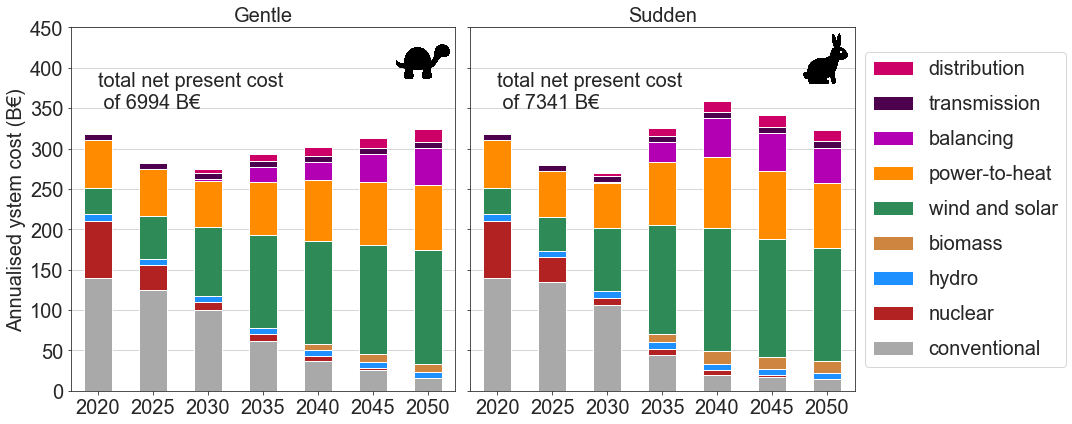

In [15]:
fig, axes = plt.subplots(1,2,figsize=(15,6),sharex=True,sharey='row')
df_sc=df_cc*total_demand/1000000000 #B€
ax = axes[0]
df = df_sc['go']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs,rot=0)
ax.set_ylim([0,450])
ax.set_xlabel('')
ax.set_ylabel("Annualised ystem cost (B€)",fontsize=fs)
ax.set_title('Gentle',fontsize=fs)
ax.grid('on',axis='y')
ax.annotate('total net present cost \n of {} B€'.format(int(s_n['go'])),xy=(0,350),fontsize=fs)
place_image(im_tortoise, loc='upper right', ax=ax, pad=0, zoom=0.1)
# ax_twin = ax.twinx()
# s_emi['go'].plot(ax=ax_twin,fontsize=fs,color='k',lw=lw)
# ax_twin.set_ylim([0,1])
# ax_twin.set_yticks([])

ax = axes[1]
df = df_sc['wait']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs,rot=0)
ax.set_xlabel('')
ax.set_title('Sudden',fontsize=fs)
ax.grid('on',axis='y')
ax.annotate('total net present cost \n of {} B€'.format(int(s_n['wait'])),xy=(0,350),fontsize=fs)
place_image(im_hare, loc='upper right', ax=ax, pad=0, zoom=0.1)
# ax_twin = ax.twinx()
# s_emi['wait'].plot(ax=ax_twin,fontsize=fs,color='k',lw=lw)
# ax_twin.set_ylim([0,1])
# ax_twin.set_ylabel("CO2 emission relative to 1990",fontsize=fs)

handles,labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1],labels[::-1],ncol=1,loc="center left",fontsize=20,bbox_to_anchor=[1,0.5],labelspacing=0.8)

fig.tight_layout()

plt.savefig('../../figures/System_cost_{}.png'.format(version),dpi=500, bbox_inches='tight')

# Plot figure with utilisation factor

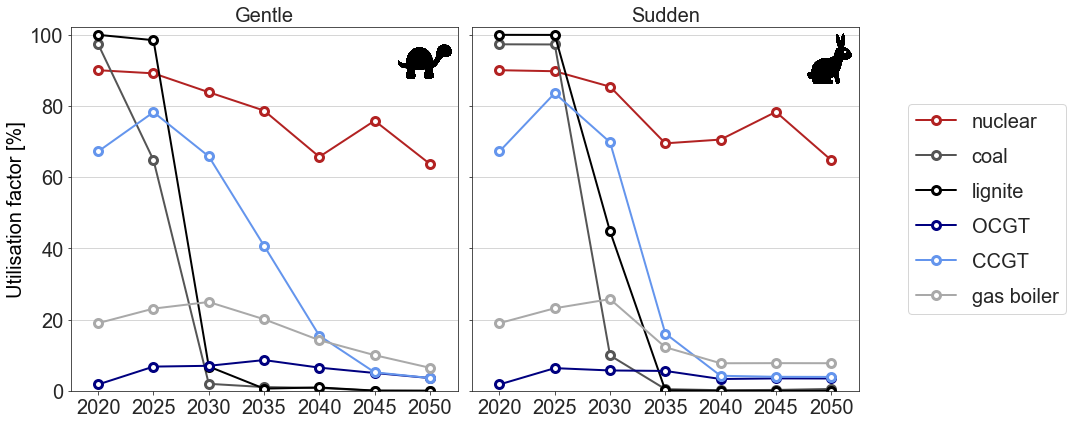

In [16]:
fig, axes = plt.subplots(1,2,figsize=(15,6),sharex=True,sharey='row')

ax = axes[0]

df = df_uti['go']*100
df.T.plot(ax=ax,fontsize=fs,color=tech_colors[df.index],lw=2,legend=False,marker='o',
          markerfacecolor='white',ms=ms,mew=mew,style='-',rot=0)
ax.set_ylabel("Utilisation factor [%]",fontsize=fs,color=tech_colors['lignite'])
ax.set_title('Gentle',fontsize=fs)
place_image(im_tortoise, loc='upper right', ax=ax, pad=0, zoom=0.1)
handles1,labels1 = ax.get_legend_handles_labels()

# ax_twinx = ax.twinx()
# df = csvs['curtailment']['go'].reindex(['offwind','onwind','solar'])
# df = df.rename(mapper=rename_techs)
# df.T.plot(ax=ax_twinx,fontsize=fs,color=tech_colors[df.index],lw=0,legend=False,marker='^',ms=ms,mew=2,style=':',alpha=0.8)
# ax_twinx.set_ylim([-0.2,7])
# ax_twinx.set_yticks([])
# handles2,labels2 = ax_twinx.get_legend_handles_labels()

# dummy plot
ax = axes[0]
df.T.plot(kind='bar',ax=ax,stacked=True,fontsize=fs,color=tech_colors[df.index],lw=lw,legend=False,alpha=0,rot=0)
ax.set_xlabel("")
ax.grid('on',axis='y')

ax = axes[1]
df = df_uti['wait']*100
df.T.plot(ax=ax,fontsize=fs,color=tech_colors[df.index],lw=2,legend=False,marker='o',
          markerfacecolor='white',ms=ms,mew=mew,style='-',rot=0)
ax.set_ylim([0,102])
ax.set_xlim([2018,2052])
ax.set_title('Sudden',fontsize=fs)
place_image(im_hare, loc='upper right', ax=ax, pad=0, zoom=0.1)

# ax_twinx = ax.twinx()
# df = csvs['curtailment']['wait'].reindex(['offwind','onwind','solar'])
# df = df.rename(mapper=rename_techs)
# df.T.plot(ax=ax_twinx,fontsize=fs,color=tech_colors[df.index],lw=0,legend=False,marker='^',ms=ms,mew=2,style=':',alpha=0.8)
# ax_twinx.set_ylim([-0.2,7])
# ax_twinx.set_ylabel('Wind and solar curtailment [%]',fontsize=fs,color=tech_colors['wind and solar'])

# dummy plot
df.T.plot(kind='bar',ax=ax,stacked=True,fontsize=fs,color=tech_colors[df.index],lw=lw,legend=False,alpha=0,rot=0)
ax.set_xlabel("")
ax.grid('on',axis='y')

ax.legend(handles1,labels1,ncol=1,loc="center left",fontsize=fs,bbox_to_anchor=[1.1,0.5],labelspacing=0.8)

fig.tight_layout()
plt.savefig('../../figures/utilisation_factors_{}.png'.format(version),dpi=500, bbox_inches='tight')

# Plot figure with market revenue v.s. total expenditure

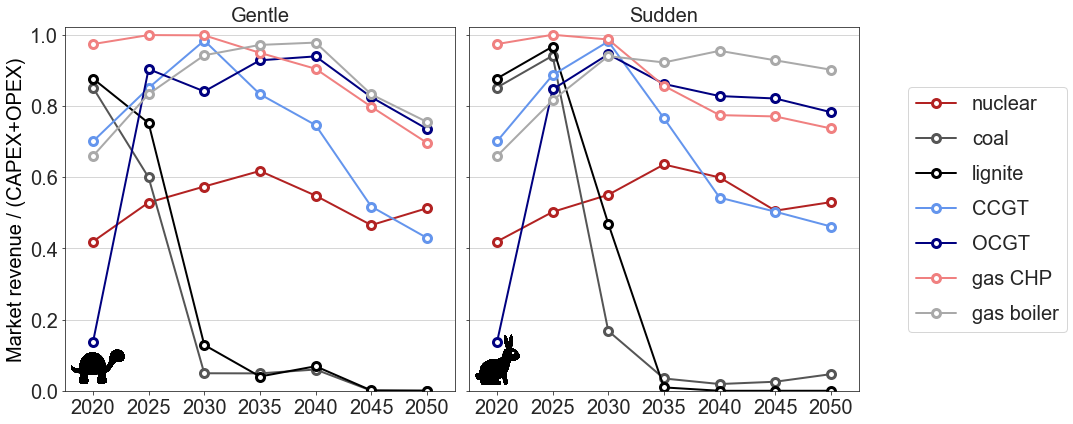

In [17]:
fig, axes = plt.subplots(1,2,figsize=(15,6),sharex=True,sharey='row')

#retrieve revenues
df = csvs['metrics']
gas_fuel_cost = df.filter(like='fuel cost',axis=0).rename(index=lambda x:x[:-10])
revenue_elec = df.filter(like='revenue',axis=0).rename(index=lambda x:x[:-8])
revenue_heat = pd.read_csv('../results/version-Base/revenue_Base.csv',index_col=0,header=[0,1])
revenue = pd.concat([revenue_elec,revenue_heat])

#retrieve capital and marginal costs
df = csvs['costs']
expenditure = df.groupby(level=2).sum().loc[revenue.index]

index = revenue.filter(like='gas CHP',axis=0).index
revenue.loc['gas CHP'] = revenue.loc[index].sum()
revenue.drop(index=index,inplace=True)
index = revenue.filter(like='gas boiler',axis=0).index
revenue.loc['gas boiler'] = revenue.loc[index].sum()
revenue.drop(index=index,inplace=True)

index = expenditure.filter(like='gas CHP',axis=0).index
expenditure.loc['gas CHP'] = expenditure.loc[index].sum()
expenditure.drop(index=index,inplace=True)
index = expenditure.filter(like='gas boiler',axis=0).index
expenditure.loc['gas boiler'] = expenditure.loc[index].sum()
expenditure.drop(index=index,inplace=True)

#Add CO2 price associated to fuel costs
expenditure.loc['CCGT'] += gas_fuel_cost.loc['CCGT']+gas_fuel_cost.loc['CCGT']/20.1*co2_intensity['gas']*csvs['metrics'].loc['co2_price']
expenditure.loc['OCGT'] += gas_fuel_cost.loc['OCGT']+gas_fuel_cost.loc['OCGT']/20.1*co2_intensity['gas']*csvs['metrics'].loc['co2_price']
expenditure.loc['lignite'] += csvs['energy'].loc[('stores','lignite store')]*co2_intensity['lignite']*csvs['metrics'].loc['co2_price']
expenditure.loc['coal'] += csvs['energy'].loc[('stores','coal store')]*co2_intensity['coal']*csvs['metrics'].loc['co2_price']
expenditure.loc['gas CHP'] += gas_fuel_cost.loc['central gas CHP']+gas_fuel_cost.loc['central gas CHP']/20.1*co2_intensity['gas']*csvs['metrics'].loc['co2_price']
expenditure.loc['gas boiler'] += gas_fuel_cost.loc['gas boiler']+gas_fuel_cost.loc['gas boiler']/20.1*co2_intensity['gas']*csvs['metrics'].loc['co2_price']

#revenue/total expenditure
df = revenue/expenditure

ax = axes[0]
df['go'].T.plot(ax=ax,fontsize=fs,color=tech_colors[df.index],lw=2,legend=False,marker='o',
                markerfacecolor='white',ms=ms,mew=mew,style='-',rot=0)
ax.set_ylabel("Market revenue / (CAPEX+OPEX)",fontsize=fs,color=tech_colors['lignite'])
ax.set_title('Gentle',fontsize=fs)
place_image(im_tortoise, loc='lower left', ax=ax, pad=0, zoom=0.1)
handles1,labels1 = ax.get_legend_handles_labels()

df['go'].T.plot(kind='bar',ax=ax,stacked=True,fontsize=fs,color=tech_colors[df.index],lw=lw,legend=False,alpha=0,rot=0)
ax.set_xlabel("")
ax.grid('on',axis='y')

ax = axes[1]
df['wait'].T.plot(ax=ax,fontsize=fs,color=tech_colors[df.index],lw=2,legend=False,marker='o',
                  markerfacecolor='white',ms=ms,mew=mew,style='-',rot=0)
ax.set_ylim([0,1.02])
ax.set_xlim([2018,2052])
ax.set_title('Sudden',fontsize=fs)
place_image(im_hare, loc='lower left', ax=ax, pad=0, zoom=0.1)
handles2,labels2 = ax.get_legend_handles_labels()

df['wait'].T.plot(kind='bar',ax=ax,stacked=True,fontsize=fs,color=tech_colors[df.index],lw=lw,legend=False,alpha=0,rot=0)
ax.set_xlabel("")
ax.grid('on',axis='y')

ax.legend(handles1,labels1,ncol=1,loc="center left",fontsize=fs,bbox_to_anchor=[1.1,0.5],labelspacing=0.8)
fig.tight_layout()
plt.savefig('../../figures/revenue_vs_expenditure_{}.png'.format(version),dpi=500, bbox_inches='tight')

# Plot figure with market revenue v.s. variable costs

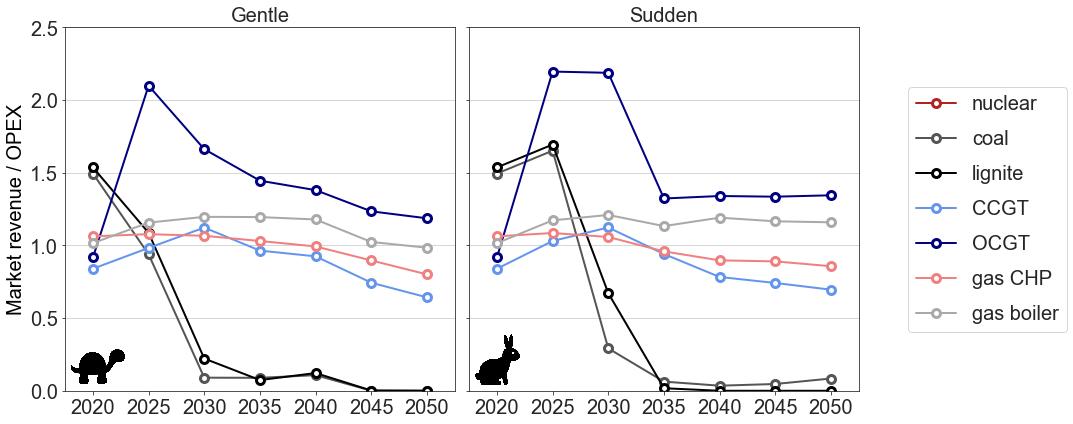

In [26]:
revenue_s=revenue
expenditure_s=expenditure

fig, axes = plt.subplots(1,2,figsize=(15,6),sharex=True,sharey='row')

#retrieve revenues
df = csvs['metrics']
gas_fuel_cost = df.filter(like='fuel cost',axis=0).rename(index=lambda x:x[:-10])
revenue_elec = df.filter(like='revenue',axis=0).rename(index=lambda x:x[:-8])
revenue_heat = pd.read_csv('../results/version-Base/revenue_Base.csv',index_col=0,header=[0,1])
revenue = pd.concat([revenue_elec,revenue_heat])

#retrieve capital and marginal costs
df = csvs['costs']

#keep only marginal costs
idx = pd.IndexSlice
df=df.loc[idx[:,'marginal',:],:]
expenditure = df.groupby(level=2).sum().loc[revenue.index]

index = revenue.filter(like='gas CHP',axis=0).index
revenue.loc['gas CHP'] = revenue.loc[index].sum()
revenue.drop(index=index,inplace=True)
index = revenue.filter(like='gas boiler',axis=0).index
revenue.loc['gas boiler'] = revenue.loc[index].sum()
revenue.drop(index=index,inplace=True)

index = expenditure.filter(like='gas CHP',axis=0).index
expenditure.loc['gas CHP'] = expenditure.loc[index].sum()
expenditure.drop(index=index,inplace=True)
index = expenditure.filter(like='gas boiler',axis=0).index
expenditure.loc['gas boiler'] = expenditure.loc[index].sum()
expenditure.drop(index=index,inplace=True)

#Add CO2 price associated to fuel costs
expenditure.loc['CCGT'] += gas_fuel_cost.loc['CCGT']+gas_fuel_cost.loc['CCGT']/20.1*co2_intensity['gas']*csvs['metrics'].loc['co2_price']
expenditure.loc['OCGT'] += gas_fuel_cost.loc['OCGT']+gas_fuel_cost.loc['OCGT']/20.1*co2_intensity['gas']*csvs['metrics'].loc['co2_price']
expenditure.loc['lignite'] += csvs['energy'].loc[('stores','lignite store')]*co2_intensity['lignite']*csvs['metrics'].loc['co2_price']
expenditure.loc['coal'] += csvs['energy'].loc[('stores','coal store')]*co2_intensity['coal']*csvs['metrics'].loc['co2_price']
expenditure.loc['gas CHP'] += gas_fuel_cost.loc['central gas CHP']+gas_fuel_cost.loc['central gas CHP']/20.1*co2_intensity['gas']*csvs['metrics'].loc['co2_price']
expenditure.loc['gas boiler'] += gas_fuel_cost.loc['gas boiler']+gas_fuel_cost.loc['gas boiler']/20.1*co2_intensity['gas']*csvs['metrics'].loc['co2_price']

#Add FOM
costs = pd.read_csv('../data/costs/outputs/costs_2020.csv',index_col=list(range(2))).sort_index()

expenditure.loc['CCGT'] += 10*csvs['metrics'].loc['CCGT capacity']*costs.loc[idx['CCGT','FOM'],'value']*costs.loc[idx['CCGT','investment'],'value'] #€/kW-> €/MW; 1/100 percentage
expenditure.loc['lignite'] += 10*csvs['metrics'].loc['lignite capacity']*costs.loc[idx['lignite','FOM'],'value']*costs.loc[idx['lignite','investment'],'value']
expenditure.loc['coal'] += 10*csvs['metrics'].loc['coal capacity']*costs.loc[idx['coal','FOM'],'value']*costs.loc[idx['coal','investment'],'value']
expenditure.loc['gas CHP'] += 10*csvs['metrics'].loc['gas CHP electric capacity']*costs.loc[idx['central gas CHP','FOM'],'value']*costs.loc[idx['central gas CHP','investment'],'value']
expenditure.loc['gas boiler'] += 10*csvs['metrics'].loc['gas boiler capacity']*costs.loc[idx['central gas boiler','FOM'],'value']*costs.loc[idx['central gas boiler','investment'],'value']

#revenue/total expenditure
df = revenue/expenditure

ax = axes[0]
df['go'].T.plot(ax=ax,fontsize=fs,color=tech_colors[df.index],lw=2,legend=False,marker='o',
                markerfacecolor='white',ms=ms,mew=mew,style='-',rot=0)
ax.set_ylabel("Market revenue / OPEX",fontsize=fs,color=tech_colors['lignite'])
ax.set_title('Gentle',fontsize=fs)
place_image(im_tortoise, loc='lower left', ax=ax, pad=0, zoom=0.1)
handles1,labels1 = ax.get_legend_handles_labels()

df['go'].T.plot(kind='bar',ax=ax,stacked=True,fontsize=fs,color=tech_colors[df.index],lw=lw,legend=False,alpha=0,rot=0)
ax.set_xlabel("")
ax.grid('on',axis='y')

ax = axes[1]
df['wait'].T.plot(ax=ax,fontsize=fs,color=tech_colors[df.index],lw=2,legend=False,marker='o',
                  markerfacecolor='white',ms=ms,mew=mew,style='-',rot=0)
ax.set_ylim([0,2.5])
ax.set_xlim([2018,2052])
ax.set_title('Sudden',fontsize=fs)
place_image(im_hare, loc='lower left', ax=ax, pad=0, zoom=0.1)
handles2,labels2 = ax.get_legend_handles_labels()

df['wait'].T.plot(kind='bar',ax=ax,stacked=True,fontsize=fs,color=tech_colors[df.index],lw=lw,legend=False,alpha=0,rot=0)
ax.set_xlabel("")
ax.grid('on',axis='y')

ax.legend(handles1,labels1,ncol=1,loc="center left",fontsize=fs,bbox_to_anchor=[1.1,0.5],labelspacing=0.8)
fig.tight_layout()
plt.savefig('../../figures/revenue_vs_variablecost_{}.png'.format(version),dpi=500, bbox_inches='tight')

# Plot figure with deficit (expenditure not recovered by market revenues)

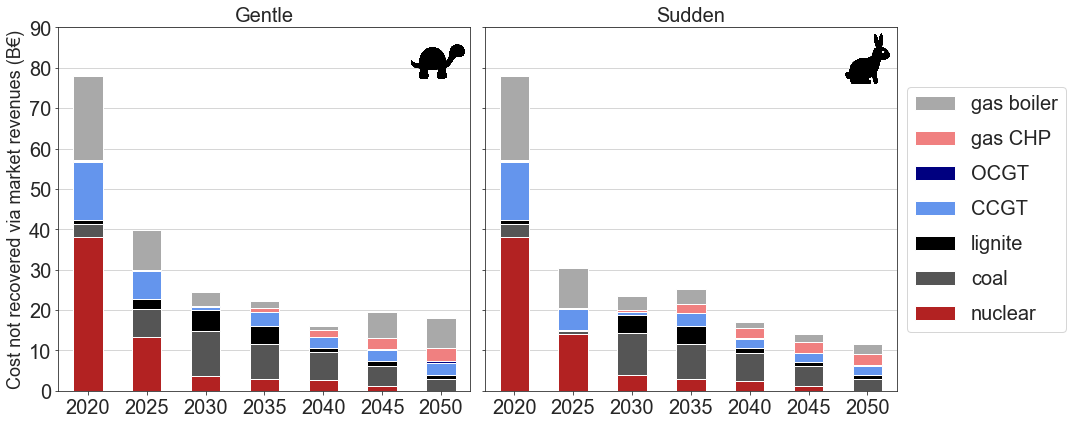

In [42]:
deficit = (-revenue_s+expenditure_s)/1e9
deficit_d=deficit.sum()
#discounted deficit
deficit_d.divide((1+rate)**(s.index.get_level_values(1).astype(int)-2020))
d_n = {}
#cumulative deficit=intermediate cost*5years
d_n['go'] = (deficit_d['go'].sum()+deficit_d['go'].iloc[1:-1].sum())/2*5
d_n['wait'] = (deficit_d['wait'].sum()+deficit_d['wait'].iloc[1:-1].sum())/2*5

fig, axes = plt.subplots(1,2,figsize=(15,6),sharex=True,sharey='row')

ax = axes[0]
df = deficit['go']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs,rot=0)
ax.set_ylim([0,90])
ax.set_xlabel('')
ax.set_ylabel("Cost not recovered via market revenues (B€)",fontsize=18)
ax.set_title('Gentle',fontsize=fs)
place_image(im_tortoise, loc='upper right', ax=ax, pad=0, zoom=0.1)
#ax.annotate('total net deficit of {} B€'.format(int(d_n['go'])),xy=(0.3,80),fontsize=fs)
ax.grid('on',axis='y')

ax = axes[1]
df = deficit['wait']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs,rot=0)
ax.set_xlabel('')
ax.set_title('Sudden',fontsize=fs)
place_image(im_hare, loc='upper right', ax=ax, pad=0, zoom=0.1)
#ax.annotate('total net deficit of {} B€'.format(int(d_n['wait'])),xy=(0.3,80),fontsize=fs)
ax.grid('on',axis='y')

handles,labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1],labels[::-1],ncol=1,loc="center left",fontsize=20,bbox_to_anchor=[1,0.5],labelspacing=0.8)

fig.tight_layout()

plt.savefig('../../figures/deficit_{}.png'.format(version),dpi=500, bbox_inches='tight')

# Plot figure with expansion rates

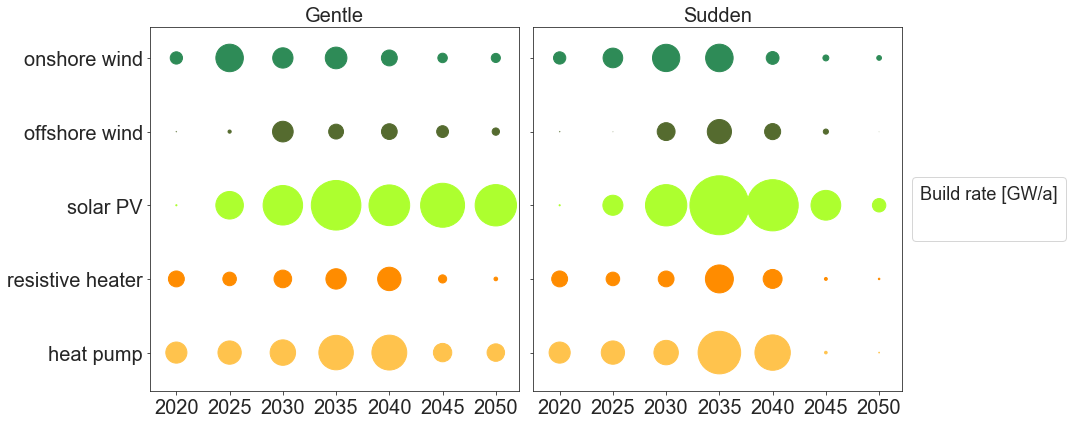

In [43]:
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
fig, axes = plt.subplots(1,2,figsize=(15,6),sharex=True,sharey='row')

scale = 25

ax = axes[0]
df = df_ex.loc[['transmission']+PtH+renewable[::-1],'go']/5
x,y = np.meshgrid(years,df.index)
scatter = ax.scatter(x=x.flatten(),y=y.flatten(),s=df.values*scale,c=[tech_colors[i] for i in y.flatten()])
ax.set_title('Gentle',fontsize=fs)
_=ax.set_xticks(np.arange(2020,2055,5))
_=ax.set_xticklabels(np.arange(2020,2055,5))

ax = axes[1]
df = df_ex.loc[['transmission']+PtH+renewable[::-1],'wait']/5
x,y = np.meshgrid(years,df.index)
ax.scatter(x=x.flatten(),y=y.flatten(),s=df.values*scale,c=[tech_colors[i] for i in y.flatten()])
ax.set_title('Sudden',fontsize=fs)
_=ax.set_xticks(np.arange(2020,2055,5))
_=ax.set_xticklabels(np.arange(2020,2055,5))

handles, labels = scatter.legend_elements(prop="sizes",alpha=0.5,num=4,func=lambda x: x/scale)
legend = ax.legend(handles,labels,ncol=1,loc="center left",fontsize=fs,bbox_to_anchor=[1,0.5],labelspacing=1.5)
legend.set_title('Build rate [GW/a]',prop={'size':fs_s})

fig.tight_layout()
plt.savefig('../../figures/build_rates_{}.png'.format(version),dpi=500,bbox_inches='tight')

# Plot figure with cumulative power and heating capacities

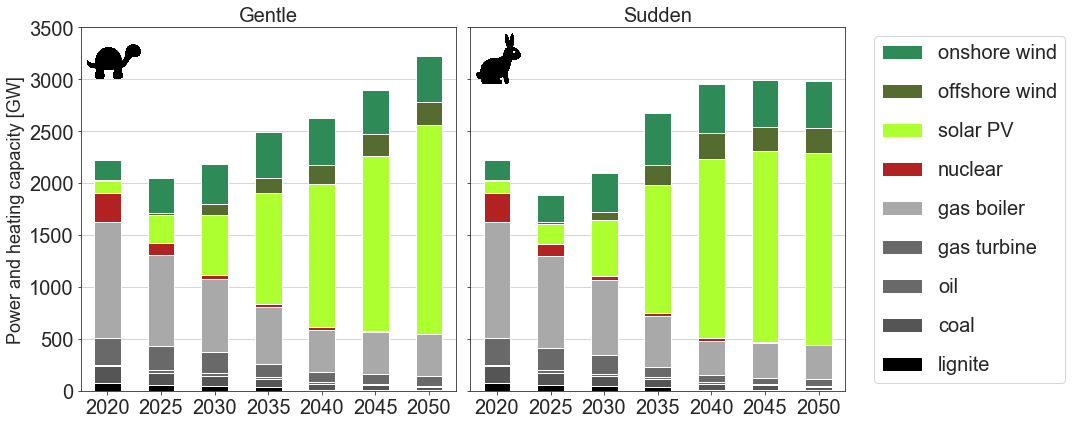

In [44]:
fig, axes = plt.subplots(1,2,figsize=(15,6),sharex=True,sharey='row')

ax = axes[0]
df = df_capa.loc[conventional+renewable[::-1],'go'].dropna()
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs,rot=0)
ax.set_xlabel('')
ax.set_ylabel("Power and heating capacity [GW]",fontsize=fs_s)
ax.set_title('Gentle',fontsize=fs)
place_image(im_tortoise, loc='upper left', ax=ax, pad=0, zoom=0.1)
ax.grid('on',axis='y')
ax.set_ylim(0,3500)

ax = axes[1]
df = df_capa.loc[conventional+renewable[::-1],'wait'].dropna()
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs,rot=0)
ax.set_xlabel('')
ax.set_title('Sudden',fontsize=fs)
place_image(im_hare, loc='upper left', ax=ax, pad=0, zoom=0.1)
ax.grid('on',axis='y')

handles,labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1],labels[::-1],ncol=1,loc="center left",fontsize=fs,bbox_to_anchor=[1.05,0.5],labelspacing=1)

fig.tight_layout()
plt.savefig('../../figures/installed_capacity_{}.png'.format(version),dpi=500, bbox_inches='tight')

# country-level electricity production

In [45]:
df = pd.read_csv('../results/version-{}/electricity_production_{}_go.csv'.format(version,version),index_col=0,header=[0,1])
index = ['lignite','coal','oil','gas','nuclear','hydro','solar','onwind','offwind']
df = df.reindex(index)
to_drop = df.index[df.max(axis=1) < 1]
df.drop(index=to_drop,inplace=True)
df.rename(index=rename_techs,inplace=True)
df_EU = df.droplevel(0,axis=1).groupby(level=0,axis=1).sum()

filename_countries = '../data/Country_codes_REINVEST_short.csv'
countries_list = pd.read_csv(filename_countries, sep=';', encoding='latin-1', index_col=3)
#dictionary to convert 2-letter country code intocountry name
dict_2toname = pd.Series(dict(zip(countries_list['2 letter code (ISO-3166-2)'].tolist(),
                countries_list['Country'].tolist())))
df.rename(mapper=dict_2toname,axis=1,inplace=True)

countries = df.columns.get_level_values(0).drop_duplicates().sort_values()

FileNotFoundError: [Errno 2] File b'../results/version-Base/electricity_production_Base_go.csv' does not exist: b'../results/version-Base/electricity_production_Base_go.csv'

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl
import seaborn as sns; sns.set()
sns.set_style('ticks')
plt.style.use('seaborn-ticks')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs

fig = plt.figure(figsize=(18,30))
gs = gridspec.GridSpec(8, 4)

for i, country in enumerate(countries):
    df_ = df[country]
    df_ = df_/df_.sum()
    to_drop = df_.index[df_.abs().max(axis=1) < 0.01]
    df_.drop(index=to_drop,inplace=True)
    ax = fig.add_subplot(gs[i//4, i-(i//4)*4])
    df_.T.plot.area(ax=ax,legend=False,color=[tech_colors[i] for i in df_.index])
    ax.set_ylim(0,1)
    ax.set_title(country, fontsize=16,pad=0)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('')
    
ax = fig.add_subplot(gs[7,3])
df_EU = df_EU/df_EU.sum()
df_EU.T.plot.area(ax=ax,color=[tech_colors[i] for i in df_EU.index])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], ncol=1,fontsize=fs_s,loc='center right',bbox_to_anchor=(-0.3,0.5))
ax.set_ylabel('Electricity production (%)', fontsize=fs)
ax.set_ylim(0,1)
ax.set_yticks(np.arange(0,1.2,0.2))
ax.set_yticklabels(np.arange(0,120,20))
ax.set_title('Europe-aggregated', fontsize=fs)
ax.set_xlabel('')
plt.savefig('../../figures/electricity_production_{}_go.png'.format(version), dpi=300, bbox_inches='tight')

# country-level heating production

In [ ]:
df = pd.read_csv('../results/version-{}/heat_production_{}_go.csv'.format(version,version),index_col=0,header=[0,1])
df.rename(index={'gas boiler':'gas','CHP heat':'gas'},inplace=True)
index = ['gas', 'resistive heater', 'heat pump']
df = df.groupby(level=0).sum().reindex(index=index)
df_EU = df.droplevel(level='country',axis=1).groupby(level=0,axis=1).sum()
df.rename(mapper=dict_2toname,axis=1,inplace=True)

countries = df.columns.get_level_values(0).drop_duplicates().sort_values()

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl
import seaborn as sns; sns.set()
sns.set_style('ticks')
plt.style.use('seaborn-ticks')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs

fig = plt.figure(figsize=(18,30))
gs = gridspec.GridSpec(8, 4)

for i, country in enumerate(countries):
    df_ = df[country]
    df_ = df_/df_.sum()
    to_drop = df_.index[df_.abs().max(axis=1) < 0.01]
    df_.drop(index=to_drop,inplace=True)
    ax = fig.add_subplot(gs[i//4, i-(i//4)*4])
    df_.T.plot.area(ax=ax,legend=False,color=[tech_colors[i] for i in df_.index])
    ax.set_ylim(0,1)
    ax.set_title(country, fontsize=16,pad=0)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('')
    
ax = fig.add_subplot(gs[7,3])
df_EU = df_EU/df_EU.sum()
df_EU.T.plot.area(ax=ax,color=[tech_colors[i] for i in df_EU.index])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], ncol=1,fontsize=fs_s,loc='center right',bbox_to_anchor=(-0.3,0.5))
ax.set_ylabel('Heat production (%)', fontsize=fs)
ax.set_ylim(0,1)
ax.set_yticks(np.arange(0,1.2,0.2))
ax.set_yticklabels(np.arange(0,120,20))
ax.set_title('Europe-aggregated', fontsize=fs)
ax.set_xlabel('')
plt.savefig('../../figures/heat_production_{}_go.png'.format(version), dpi=300, bbox_inches='tight')